## 問題設定

状態ベクトルの次元$n=2$, 入力制御ベクトルの次元$m=1$とし, 線形システム

$$ \dot{x}(t) = f(x(t),u(t))$$

を考える. ここで
$$
f(x,t) = \begin{bmatrix} x_2\\ -x_1^3+x_1 -x_2 + u\end{bmatrix}
$$
とし, 初期値は
$$
x(0)=\begin{bmatrix} 0.1\\ 0\end{bmatrix}
$$

とする. 評価関数は

$$
J=\dfrac12 x^T(T) S_Tx(T) + \int_0^T\dfrac12\left(x^T(t)Qx(t) + u^T(t)Ru(t)\right)\, dt, \quad T=5
$$

において
$$
S_f=Q=\begin{bmatrix} 13& 0\\ 0&1\end{bmatrix},\quad
R=\begin{bmatrix} 1 \end{bmatrix}
$$
とする. すなわち

$$
J=\dfrac12 \left(13x_1(T)^2 + x_2(T)^2 \right) +\dfrac12 \int_0^T\left(13x_1(t)^2 + x_2(t)^2 +u(t)^2\right)\, dt.
$$

を最小化する最適制御を考える.

## 制御入力がない場合
まず, 制御入力がなかった場合($u=0$)のダイナミクスを明らかにする

In [1]:
import diffrax
import jax.numpy as jnp
from tqdm.notebook import tqdm_notebook as tqdm

# 問題設定
S_f = jnp.array([[13, 0], [0, 1]], dtype=float)
Q = jnp.array([[13, 0], [0, 1]], dtype=float)
R = jnp.array([[1]], dtype=float)

x_0 = jnp.array([[0.1], [0]], dtype=float)

# 解く区間
t0, t1 = 0, 8
dt = 0.01

# diffrax の出力数
N = 8000

In [2]:
import jax


@jax.jit
def compute_J(x, u):
    N = x.shape[0]  # サンプル数
    dt = (t1 - t0) / N  # 時間刻み

    x_T = x[-1]  # 最後の時刻の状態, 形状は (n, 1)
    terminal_cost = 0.5 * jnp.matmul(x_T.T, jnp.matmul(S_f, x_T)).squeeze()

    xQx = jnp.einsum("nkj,ki,nij->n", x, Q, x)  # 形状は (N,)
    uRu = jnp.einsum("nkj,ki,nij->n", u, R, u)  # 形状は (N,)
    integral_cost = 0.5 * jnp.sum(xQx + uRu) * dt

    # 総コスト J の計算
    J = terminal_cost + integral_cost
    return jnp.sum(J)

In [3]:
# 汎用設定
ts = jnp.linspace(t0, t1, N)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=ts)

In [4]:
@jax.jit
def function_f(x, u):
    x1, x2 = x
    u1 = u.squeeze()
    return jnp.array([x2, -(x1**3) + x1 - x2 + u1], dtype=float)


def vector_field_x(t, x, args):
    u_t = args.evaluate(t)
    return function_f(x, u_t)


state_eq = diffrax.ODETerm(vector_field_x)

In [5]:
import matplotlib.pyplot as plt


def plot_control(u):
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys
    X = jnp.array(x).reshape(N, 2)
    U = jnp.array(u).reshape(N, 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for k in range(2):
        plt.plot(ts, X[:, k], label=f"x_{k}")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
    plt.legend()

    plt.subplot(1, 2, 2)
    for k in range(1):
        plt.plot(ts, U[:, k], linestyle="--", label="u")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
    plt.legend()
    plt.show()

    print("score=", compute_J(x, u))

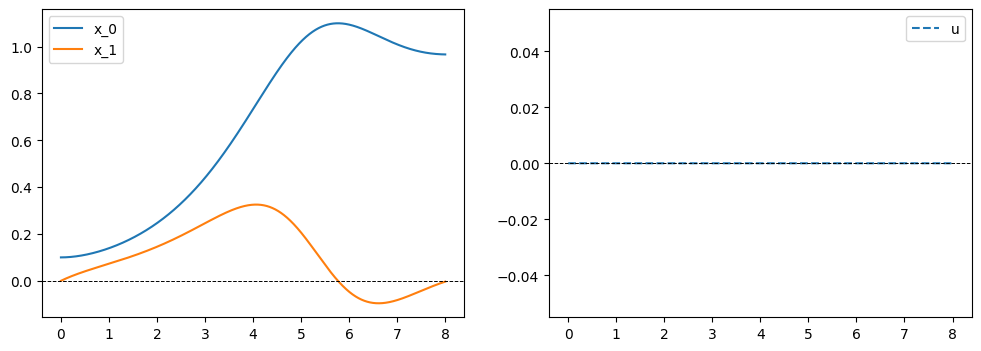

35.732365


In [6]:
u = jnp.zeros((N, 1, 1))
plot_control(u)

オイラー・ラグランジュ方程式

$$\begin{aligned}
&\dot{x}(t) = Ax(t) + Bu(t),
\quad x(0)=x_0, \\
&\dot{\lambda}(t) =-Qx(t)-A^T \lambda(t) , 
\quad \lambda(t_f) =  S_f (x(t_f)), \\
&u^T(t)R + \lambda^T(t)B=0.
\end{aligned}$$

に対して, ハミルトニアンを$H=L+\lambda^T f$とする.

## 最急降下法

以下のアルゴリズムを構築する

1. 適当な$u$を制御入力の初期推定解とする
2. $u$を用いて状態方程式を解いて$x$を, 随伴方程式を解いて$\lambda$を求める
3. $x$,$u$,$\lambda$から$\frac{\partial H}{\partial u}$を計算する. 
    * 勾配のノルム$\left(\int_{t_0}^{t_f}\left\|\frac{\partial H}{\partial u}\right\|^2\right)^{\frac{1}{2}}$が十分小さければ停止する
4. $s=-\left(\frac{\partial H}{\partial u}\right)^T$とおく
5. 制御入力を $u+\alpha s$としたときの評価関数値$J[u+\alpha s]$が最小になるスカラー$\alpha$を求め, $u=u+\alpha s$と更新してステップ2に戻る

In [7]:
import jax


@jax.jit
def hamiltonian(x, u, lambda_):
    L = 0.5 * (jnp.matmul(x.T, jnp.matmul(Q, x)) + jnp.matmul(u.T, jnp.matmul(R, u)))
    f = function_f(x, u)
    H = L + jnp.matmul(lambda_.T, f)
    return H.squeeze()


grad_H_x = jax.grad(hamiltonian, argnums=0)


def vector_field_lambda(t, lambda_, args):
    x_t = args[0].evaluate(t)
    u = args[1].evaluate(t)
    dot_lambda = grad_H_x(x_t, u, lambda_)
    return dot_lambda


lambda_eq = diffrax.ODETerm(vector_field_lambda)


@jax.jit
def compute_sequential_hamiltonian_and_gradients(x, u, lambda_):
    """
    各時刻におけるハミルトニアンとその u に関する勾配を計算します。

    Parameters:
    x (jnp.array): 状態変数、形状は (N, n, 1)
    u (jnp.array): 制御入力、形状は (N, m, 1)
    lambda_ (jnp.array): ラグランジュ乗数、形状は (N, n, 1)

    Returns:
    Tuple[jnp.array, jnp.array]: ハミルトニアンの配列と勾配の配列
    """
    # ベクトル化されたハミルトニアン関数
    H = jax.vmap(hamiltonian, in_axes=(0, 0, 0))(x, u, lambda_)
    # ベクトル化された勾配関数
    hamiltonian_grad_u = jax.grad(hamiltonian, argnums=1)
    grad_u = jax.vmap(hamiltonian_grad_u, in_axes=(0, 0, 0))(x, u, lambda_)
    return H, grad_u

In [8]:
@jax.jit
def J_alpha(alpha, u, s):
    u_new = u + alpha * s
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u_new)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x_new = sol.ys
    return compute_J(x_new, u_new)

In [9]:
from scipy.optimize import minimize_scalar

u = jnp.zeros((N, 1, 1))
eps1 = 1e-2
eps2 = 1e-7

for i in tqdm(range(10**4)):
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys

    lambda_tf = S_f @ x[-1]
    x_func = diffrax.LinearInterpolation(ts=ts, ys=x[::-1])
    sol = diffrax.diffeqsolve(lambda_eq, solver, t0, t1, dt, lambda_tf, args=[x_func, u_func], saveat=saveat)
    lambda_ = sol.ys[::-1]

    H, grad_u = compute_sequential_hamiltonian_and_gradients(x, u, lambda_)

    # u の更新
    grad_norm = jnp.sqrt(jnp.sum(grad_u**2) * dt)
    if grad_norm < eps1:
        print(f"roop done for {i=}, because {grad_norm=:.5f}")
        break

    score = compute_J(x, u)
    s = -grad_u
    alpha_opt = minimize_scalar(J_alpha, bounds=(0, 1), args=(u, s)).x

    u += alpha_opt * s
    diff_norm = alpha_opt * jnp.sqrt(jnp.sum(s**2) * dt)
    if i % 100 == 0:
        print(f"{score=:.7f}, {grad_norm=:.5f}, {diff_norm=:.8f}")
    if diff_norm < eps2:
        print(f"roop done for {i=}, because {diff_norm=:.8f}")
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

score=35.7323647, grad_norm=176.92572, diff_norm=0.58082980
score=0.1066883, grad_norm=2.23705, diff_norm=0.00027668
score=0.0918839, grad_norm=6.07426, diff_norm=0.00008533
score=0.0797121, grad_norm=0.91952, diff_norm=0.00010955
score=0.0746974, grad_norm=1.24859, diff_norm=0.00001947
score=0.0732838, grad_norm=0.48109, diff_norm=0.00019676
score=0.0684848, grad_norm=0.11498, diff_norm=0.00000279
score=0.0684389, grad_norm=0.06314, diff_norm=0.00000244
score=0.0684360, grad_norm=0.05089, diff_norm=0.00001757
score=0.0684066, grad_norm=0.04439, diff_norm=0.00000215
score=0.0683984, grad_norm=0.19250, diff_norm=0.00000316
score=0.0683967, grad_norm=0.20705, diff_norm=0.00000146
score=0.0683663, grad_norm=0.12670, diff_norm=0.00000320
score=0.0683659, grad_norm=0.11020, diff_norm=0.00000227
score=0.0683653, grad_norm=0.04419, diff_norm=0.00000295
score=0.0683646, grad_norm=0.02318, diff_norm=0.00000431
score=0.0683642, grad_norm=0.22755, diff_norm=0.00000371
score=0.0683629, grad_norm=0

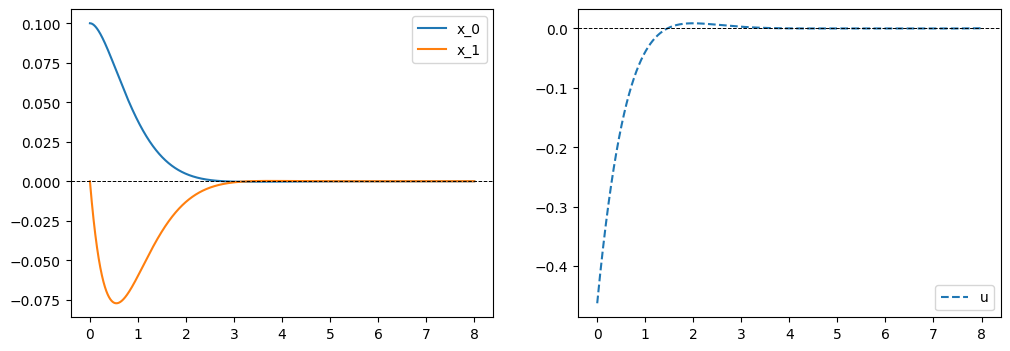

0.068354204


In [10]:
plot_control(u)

## 共役勾配法


以下のアルゴリズムを構築する

1. 適当な$u$を制御入力の初期推定解, $s_-=0$, $d_-$は適当（計算に使われない）に置く
2. 制御入力を $u$ としたときの状態方程式の解$x$, 随伴方程式の解$\lambda$ に対して$d = -\frac{\partial H}{\partial u}$ とする
    * 勾配のノルム$\left(\int_{t_0}^{t_f}\left\|d(t)\right\|^2\,dt\right)^{\frac{1}{2}}$が十分小さければ停止する
3. ポラックリビエポリャック法やフレッチャーリーブス法により$\beta$を$d_-, d$ から定める
4. $s=d + \beta s_-$とする
5. 制御入力を $u+\alpha s$としたときの評価関数値$J[u+\alpha s]$が最小になるスカラー$\alpha$を求め, $u=u+\alpha s$とおく
6. $d_-=d, s_-=s$と代入する
7. 共役方向の誤差が蓄積するので定期的にリセットする（よくわからない）

In [11]:
u = jnp.zeros((N, 1, 1))
s_ = jnp.zeros((N, 1, 1))
d_ = jnp.ones((N, 1, 1))

eps1 = 1e-2
eps2 = 1e-7

for i in tqdm(range(10**4)):
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys

    lambda_tf = S_f @ x[-1]
    x_func = diffrax.LinearInterpolation(ts=ts, ys=x[::-1])
    sol = diffrax.diffeqsolve(lambda_eq, solver, t0, t1, dt, lambda_tf, args=[x_func, u_func], saveat=saveat)
    lambda_ = sol.ys[::-1]

    H, grad_u = compute_sequential_hamiltonian_and_gradients(x, u, lambda_)
    d = -grad_u

    grad_norm = jnp.sqrt(jnp.sum(d**2) * dt).squeeze()
    if grad_norm < eps1:
        print(f"roop done for {i=}, because {grad_norm=:.5f}")
        break

    beta = jnp.einsum("ijk, ijk", d, d - d_) / jnp.einsum("ijk, ijk", d_, d_)  # ポラックリビエポリャック法
    # beta = jnp.einsum("ijk, ijk", d, d) / jnp.einsum("ijk, ijk", d_, d_)  # フレッチャーリーブス法
    s = d + beta * s_
    alpha_opt = minimize_scalar(J_alpha, bounds=(0, 1), args=(u, s)).x
    score = compute_J(x, u)

    u += alpha_opt * s

    diff_norm = alpha_opt * jnp.sqrt(jnp.sum(s**2) * dt)
    d_ = d
    s_ = s
    if diff_norm < eps2:
        print(f"roop done for {i=}, because {diff_norm=:.8f}")
        break
    if i % 3 == 0:
        # s_ には共役方向の誤差が蓄積するので定期的にリセットする
        s_ = jnp.zeros((N, 1, 1))
    if i % 100 == 0:
        print(f"{score=:.7f}, {grad_norm=:.5f}, {diff_norm=:.8f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

score=35.7323647, grad_norm=176.92572, diff_norm=0.58082980
roop done for i=100, because grad_norm=0.00929


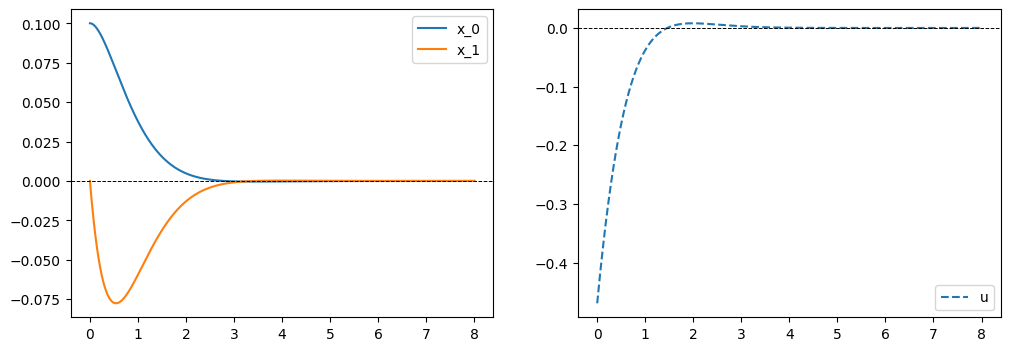

0.06834819


In [12]:
plot_control(u)